# Intro to Time Series Analysis  

In [217]:
import pandas as pd
import numpy as np
import geopandas as gp
import requests
import io 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
%matplotlib inline

### Import the Data
Access the Canadian climate data api, and download the climate data for the Glacier NP, Rogers Pass weather station which can be found here: [Here](https://climate.weather.gc.ca/climate_data/daily_data_e.html?hlyRange=%7C&dlyRange=1965-06-01%7C2014-07-30&mlyRange=1965-01-01%7C2007-02-01&StationID=1363&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=0&searchMethod=contains&Month=12&Day=10&txtStationName=rogers+pass&timeframe=2&Year=2011)

In [12]:
response = requests.get('https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=1345&Year=1980&Month=11&Day=14&timeframe=2&submit= Download+Data')
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
#create a list of years we are interested in to iterate the api request through
years = np.linspace(1981, 2018, dtype=int, num = 38)

#Take each response, which is returned as an encoded CSV file, and append it to a Pandas Data Frame
for i in years:
    i = i.astype(int)
    response = requests.get(f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=1345&Year={i}&Month=11&Day=14&timeframe=2&submit= Download+Data")
    if response.status_code == 200: #200 is an HTTP status code that means "everything is ok". ITs good to check the status_code in an if statement to avoid throwing and error
        df_temp = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
        df = df.append(df_temp)
        print(f'Appended year {i} and the size of the new df is {df.shape}')
    else:
        print("Error: unable to retrieve weather data.  Server responded with status code", response.status_code)  

Appended year 1981 and the size of the new df is (731, 31)
Appended year 1982 and the size of the new df is (1096, 31)
Appended year 1983 and the size of the new df is (1461, 31)
Appended year 1984 and the size of the new df is (1827, 31)
Appended year 1985 and the size of the new df is (2192, 31)
Appended year 1986 and the size of the new df is (2557, 31)
Appended year 1987 and the size of the new df is (2922, 31)
Appended year 1988 and the size of the new df is (3288, 31)
Appended year 1989 and the size of the new df is (3653, 31)
Appended year 1990 and the size of the new df is (4018, 31)
Appended year 1991 and the size of the new df is (4383, 31)
Appended year 1992 and the size of the new df is (4749, 31)
Appended year 1993 and the size of the new df is (5114, 31)
Appended year 1994 and the size of the new df is (5479, 31)
Appended year 1995 and the size of the new df is (5844, 31)
Appended year 1996 and the size of the new df is (6210, 31)
Appended year 1997 and the size of the ne

### Check to see if we have time series data

In [8]:
#Preview the Data
df.head()

,Longitude_(x),Latitude_(y),Station_Name,Climate_ID,Date/Time,Year,Month,Day,Data_Quality,Max_Temp_(°C),...,Total_Snow_(cm),Total_Snow_Flag,Total_Precip_(mm),Total_Precip_Flag,Snow_on_Grnd_(cm),Snow_on_Grnd_Flag,Dir_of_Max_Gust_(10s_deg),Dir_of_Max_Gust_Flag,Spd_of_Max_Gust_(km/h),Spd_of_Max_Gust_Flag
0,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-01,1980,1,1,NaN,-3.0,...,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-02,1980,1,2,NaN,-4.0,...,7.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-03,1980,1,3,NaN,-7.5,...,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-04,1980,1,4,NaN,-7.0,...,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-05,1980,1,5,NaN,-11.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Is the Date/Time/Month/Day/Year columns, actually Date/Time?

In [212]:

df.dtypes


Longitude_(x)                       float64
Latitude_(y)                        float64
Station_Name                         object
Climate_ID                           object
Date/Time                    datetime64[ns]
Year                                  int64
Month                                 int64
Day                                   int64
Data_Quality                         object
Max_Temp_(°C)                       float64
Max_Temp_Flag                        object
Min_Temp_(°C)                       float64
Min_Temp_Flag                        object
Mean_Temp_(°C)                      float64
Mean_Temp_Flag                       object
Heat_Deg_Days_(°C)                  float64
Heat_Deg_Days_Flag                   object
Cool_Deg_Days_(°C)                  float64
Cool_Deg_Days_Flag                   object
Total_Rain_(mm)                     float64
Total_Rain_Flag                      object
Total_Snow_(cm)                     float64
Total_Snow_Flag                 

In [27]:
#clean up column names
df.columns = [c.replace(' ', '_') for c in df.columns]


## Using .to_datetime

In [213]:
#create datetime objects out of the strings, and set Date/Time to the index
date_converted = pd.to_datetime(df['Date/Time'])
df['Date/Time']=date_converted
df= df.set_index(df['Date/Time'])

In [214]:
df.head()

,Longitude_(x),Latitude_(y),Station_Name,Climate_ID,Date/Time,Year,Month,Day,Data_Quality,Max_Temp_(°C),...,Total_Snow_(cm),Total_Snow_Flag,Total_Precip_(mm),Total_Precip_Flag,Snow_on_Grnd_(cm),Snow_on_Grnd_Flag,Dir_of_Max_Gust_(10s_deg),Dir_of_Max_Gust_Flag,Spd_of_Max_Gust_(km/h),Spd_of_Max_Gust_Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
1980-01-01,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-01,1980,1,1,NaN,-3.0,...,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-02,1980,1,2,NaN,-4.0,...,7.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-03,1980,1,3,NaN,-7.5,...,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-04,1980,1,4,NaN,-7.0,...,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,-117.7,51.24,GLACIER NP MT FIDELITY,117CA90,1980-01-05,1980,1,5,NaN,-11.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizing the data

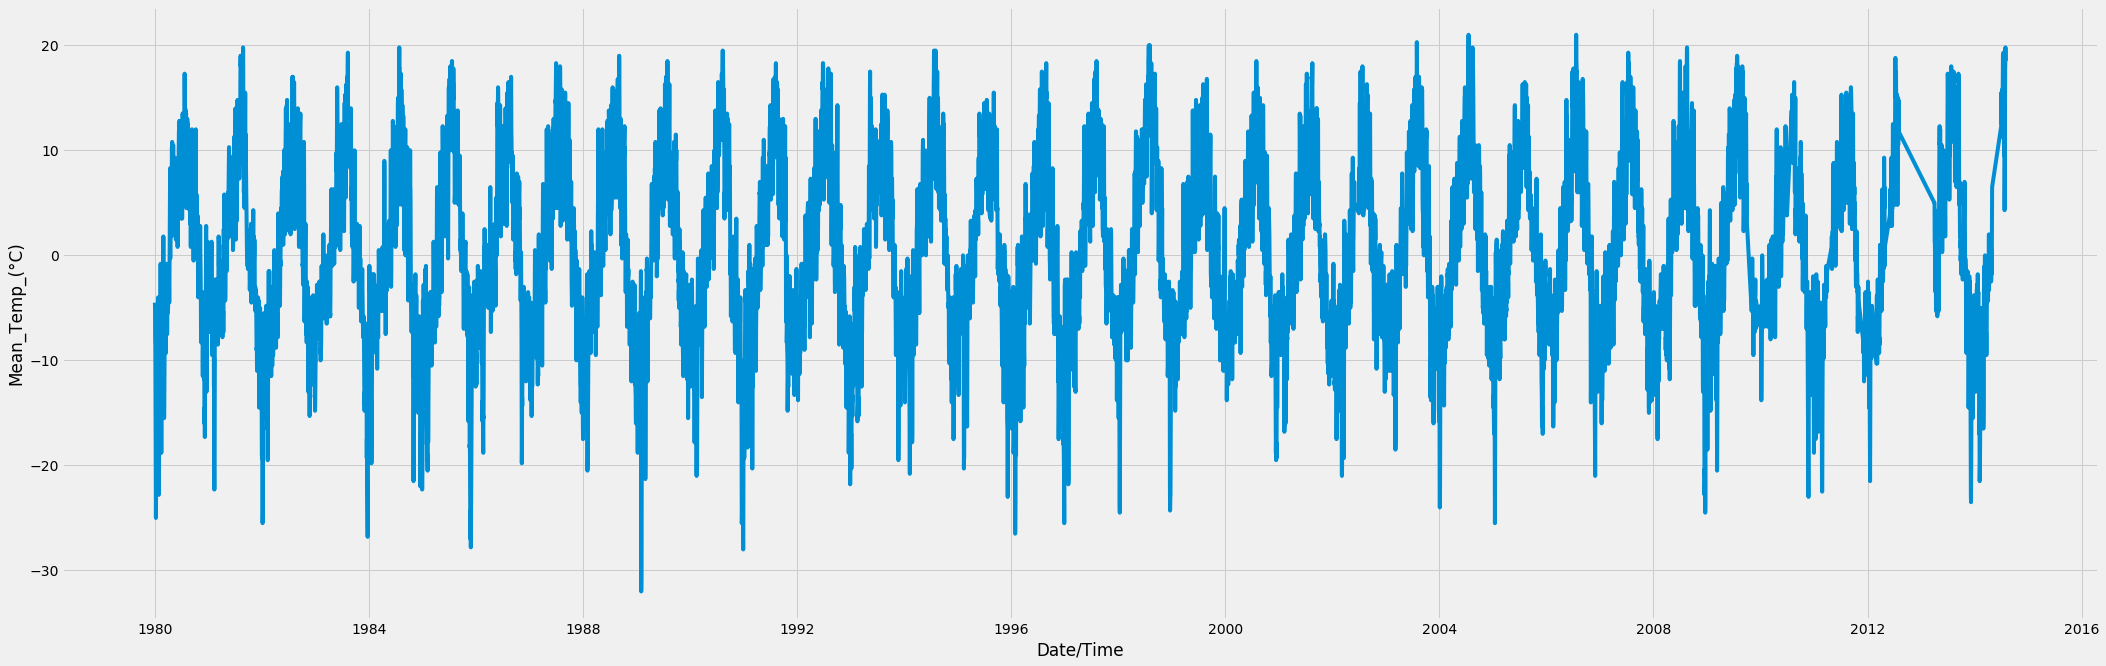

In [41]:
# Visualize the data... lets take a look at the daily mean temp
plt.style.use("fivethirtyeight") #Fivethirtyeight is a good style for time series analysis 

fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(df.index, y=df["Mean_Temp_(°C)"], ax=axs)

### Just as we expected. A seasonal cycle. What if we just wanted to look at a given time frame? 

We can index for both a specific time stamp or a time period as follows:

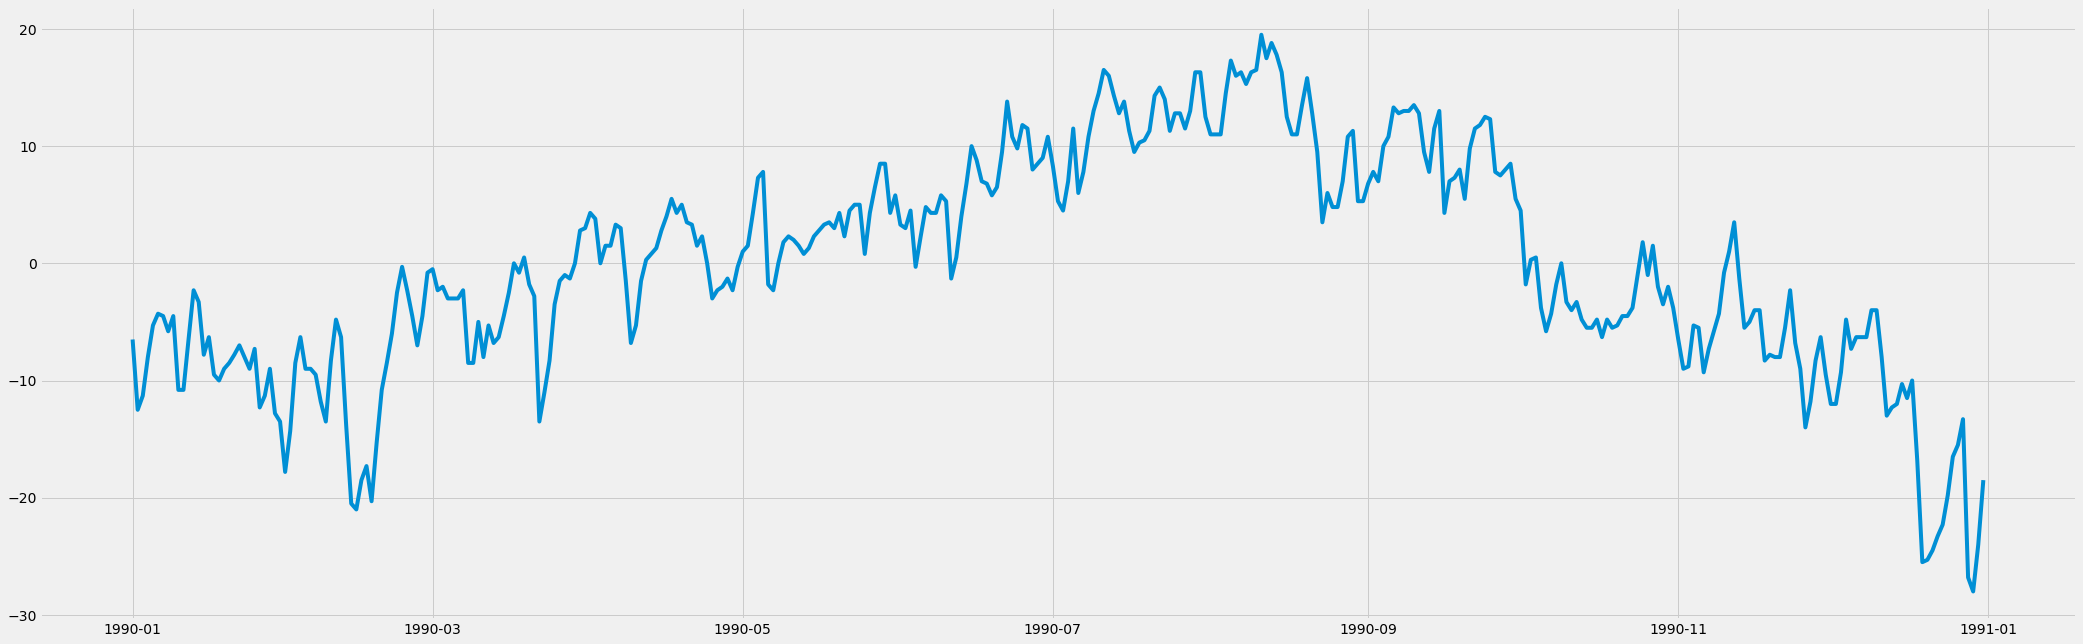

In [53]:
#Use date time indexing for a single year
fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data= df["Mean_Temp_(°C)"]['1990'], ax=axs)

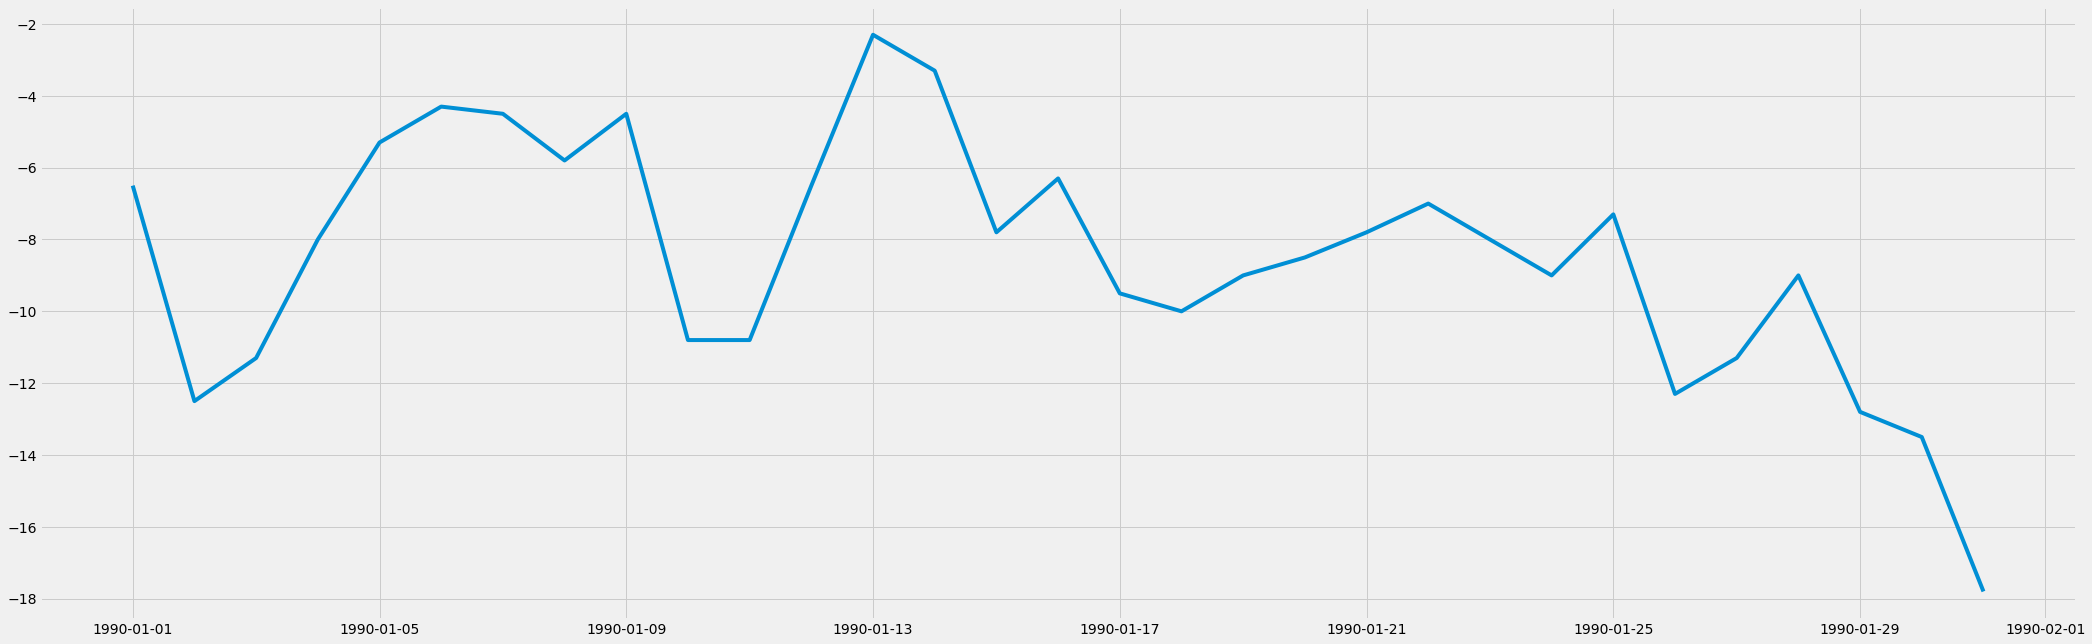

In [54]:
#Use date time indexing for a single month
fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data= df["Mean_Temp_(°C)"]['1990-01'], ax=axs)

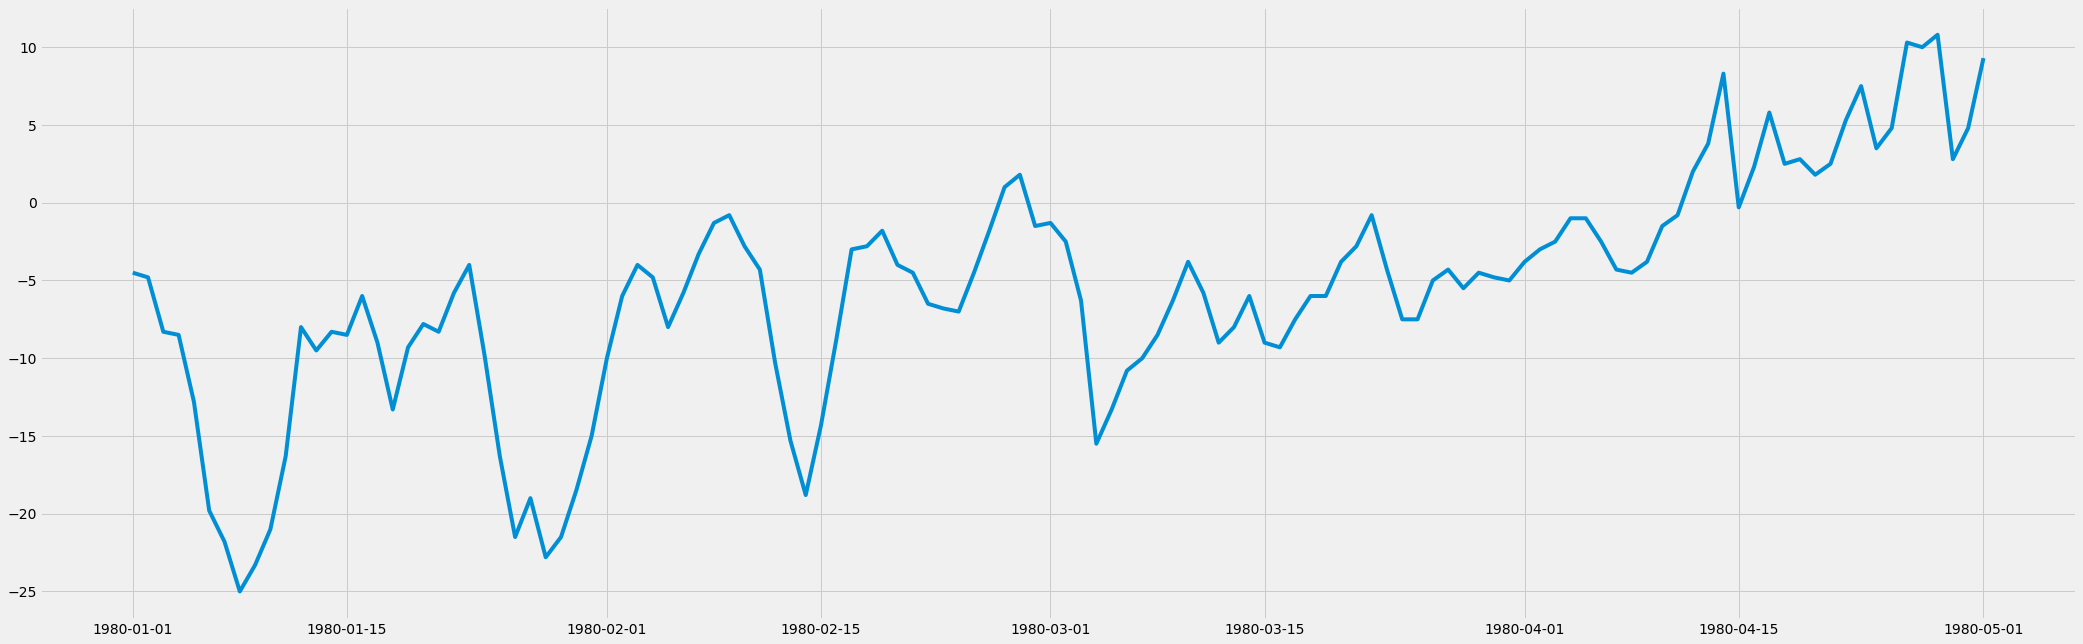

In [81]:
#Use date time indexing for time period
fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data= df['1980-01-01':'1980-05-01']["Mean_Temp_(°C)"], ax=axs)

## Resampling:


### Downsampling:

From more frequent, to less frequent. Results in courser resolution. Loss of precision. "Smoother"



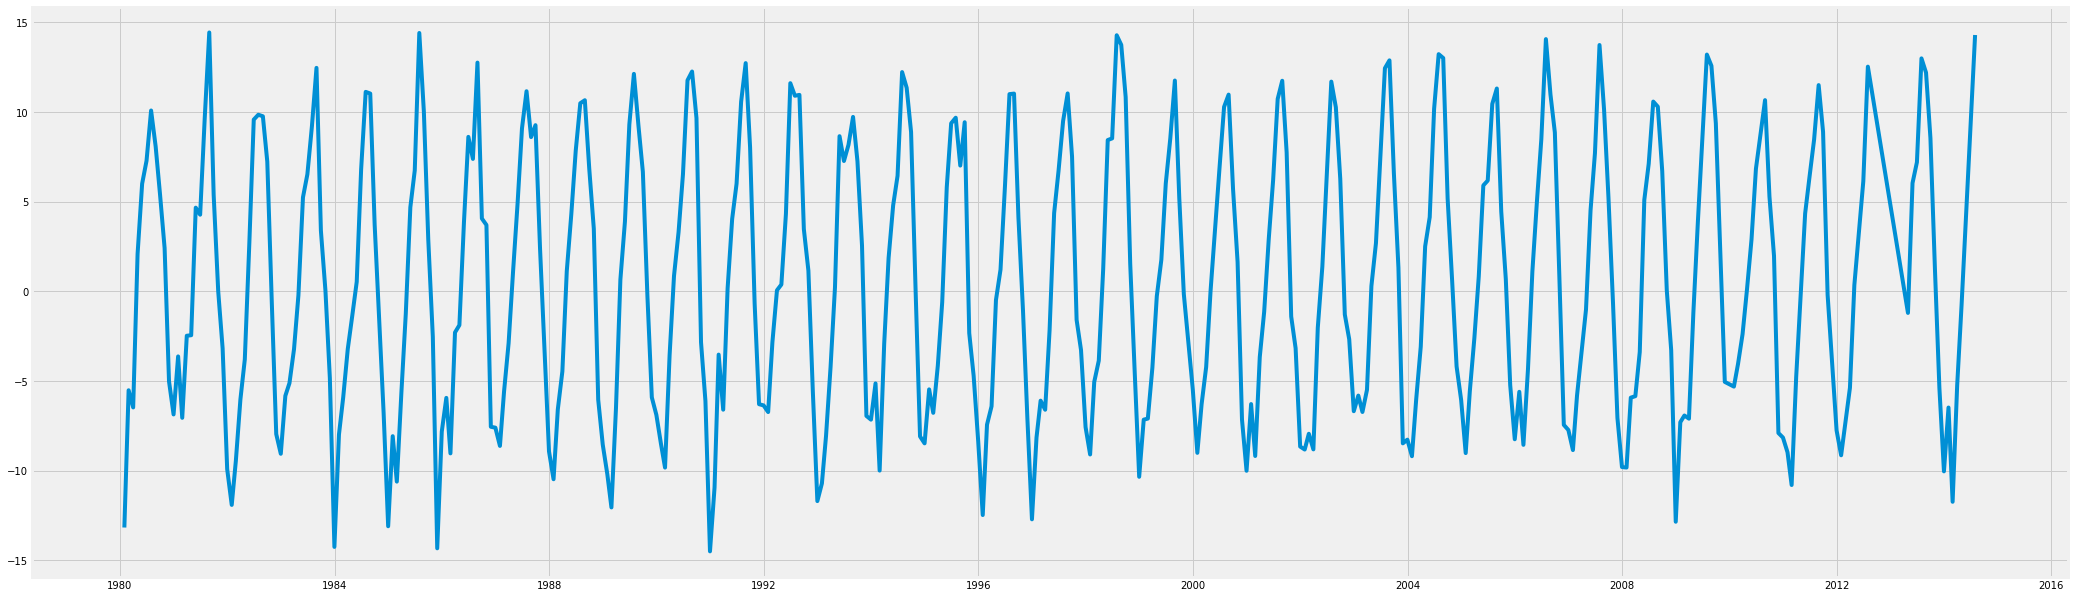

In [215]:
#Visualizing the daily temperature for 29 years is pretty noisy, can we smooth it out? 

fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data = df["Mean_Temp_(°C)"].resample('M').mean(), ax=axs)


### Upsampling: 

From less frequent measurments to more frequent measurments. Results in finer resolution. Loss of accuracy. Interpolation.

- We use .ffill() to resample our data. Other options are .bffill() and .pad(). Notice how much these small changes change
  the information being convayed!
    

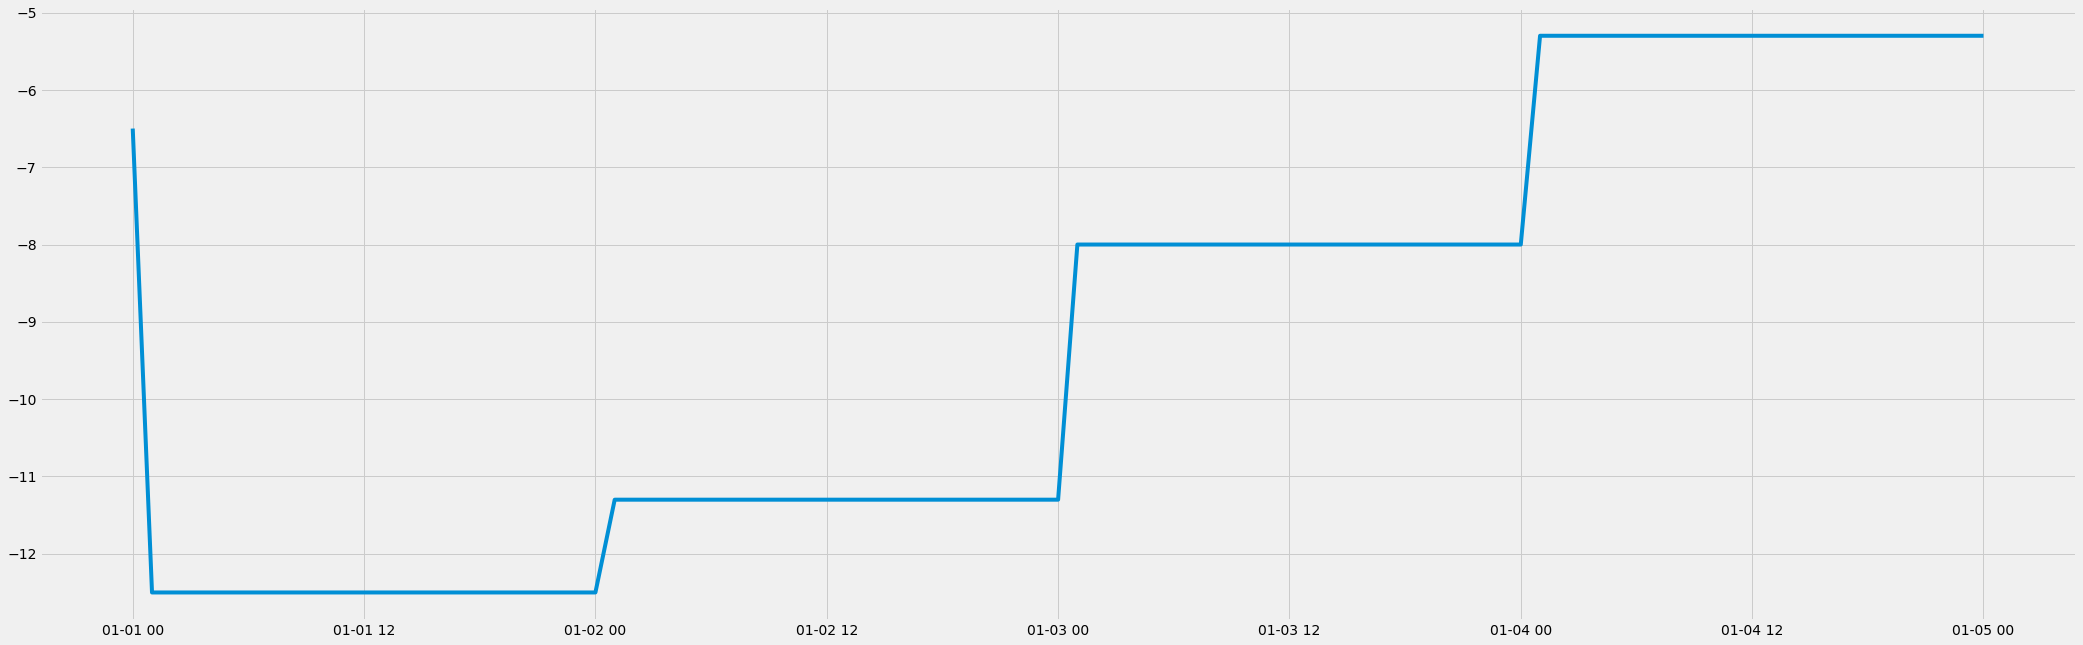

In [124]:

fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data = df['1990-01-01':'1990-01-05']["Mean_Temp_(°C)"].resample('H').bfill(), ax=axs)

With a little common knowledge of natural processes we know it should look more like this option, with no fill values and basic interpolation:

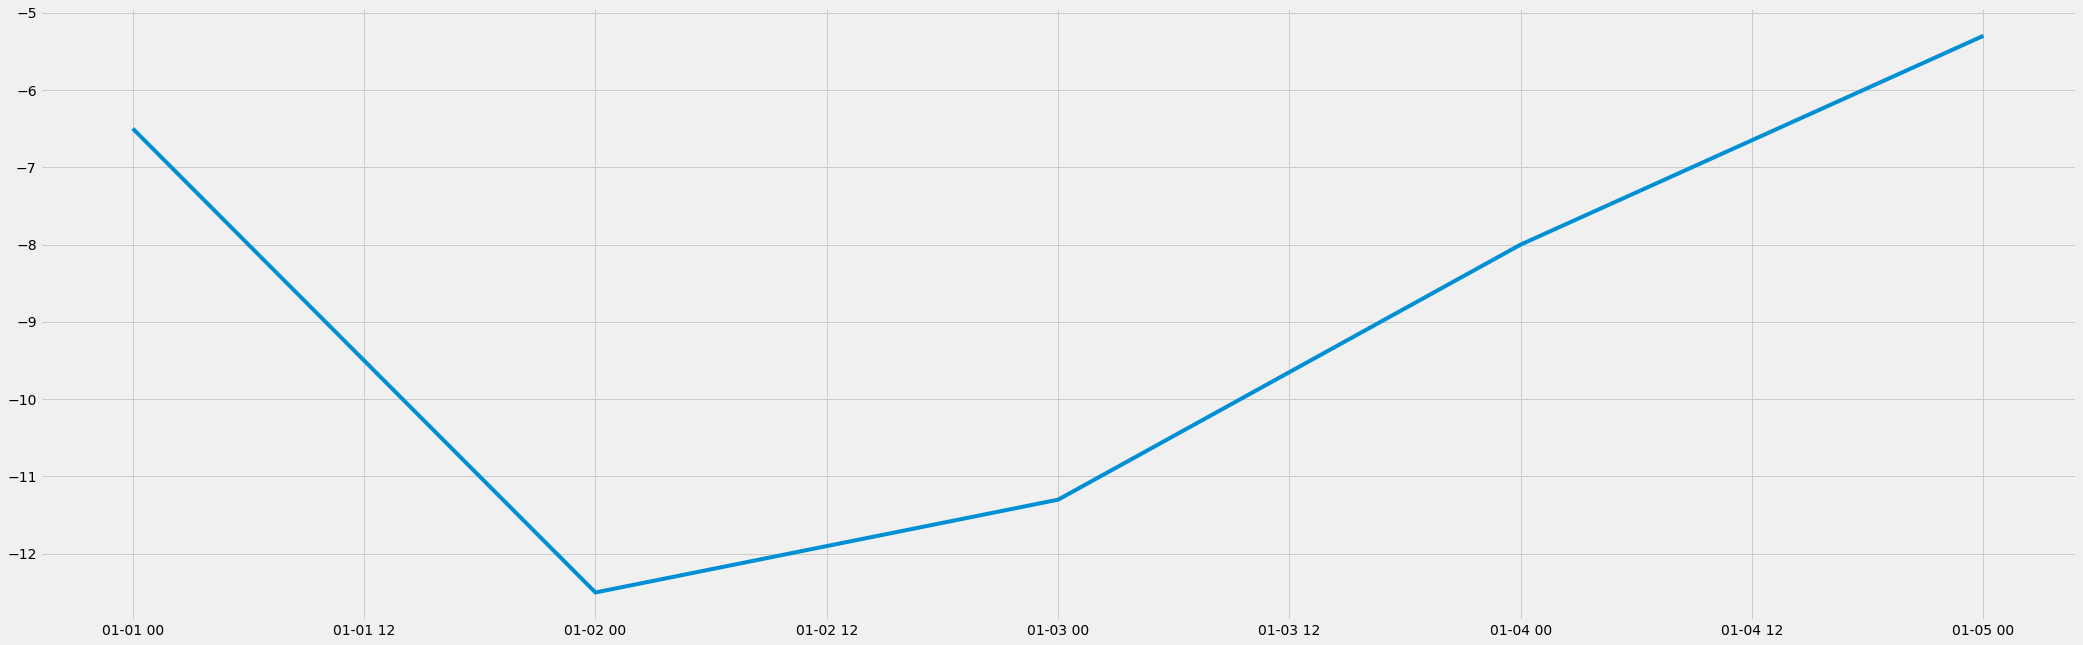

In [113]:
fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data = df['1990-01-01':'1990-01-05']["Mean_Temp_(°C)"].asfreq('H'), ax=axs)


In [125]:
df.columns

Index(['Longitude_(x)', 'Latitude_(y)', 'Station_Name', 'Climate_ID',
       'Date/Time', 'Year', 'Month', 'Day', 'Data_Quality', 'Max_Temp_(°C)',
       'Max_Temp_Flag', 'Min_Temp_(°C)', 'Min_Temp_Flag', 'Mean_Temp_(°C)',
       'Mean_Temp_Flag', 'Heat_Deg_Days_(°C)', 'Heat_Deg_Days_Flag',
       'Cool_Deg_Days_(°C)', 'Cool_Deg_Days_Flag', 'Total_Rain_(mm)',
       'Total_Rain_Flag', 'Total_Snow_(cm)', 'Total_Snow_Flag',
       'Total_Precip_(mm)', 'Total_Precip_Flag', 'Snow_on_Grnd_(cm)',
       'Snow_on_Grnd_Flag', 'Dir_of_Max_Gust_(10s_deg)',
       'Dir_of_Max_Gust_Flag', 'Spd_of_Max_Gust_(km/h)',
       'Spd_of_Max_Gust_Flag'],
      dtype='object')

## Window Functions:

Using resample method to calculate window computations is easy!


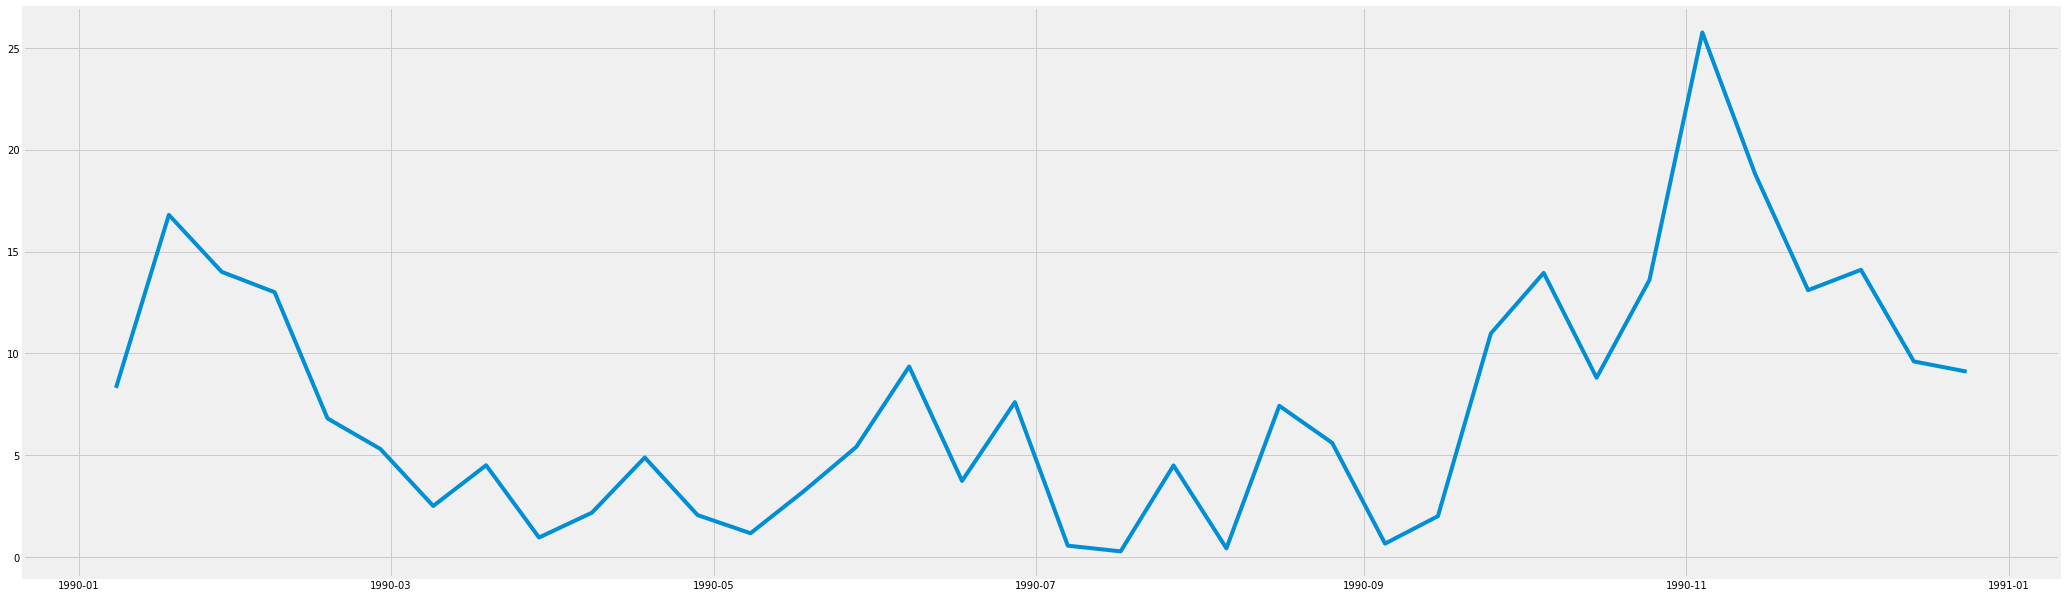

In [186]:
rolling_month_df = df['Total_Precip_(mm)'].resample('10D').mean()

fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data = rolling_month_df['1990'], ax=axs)

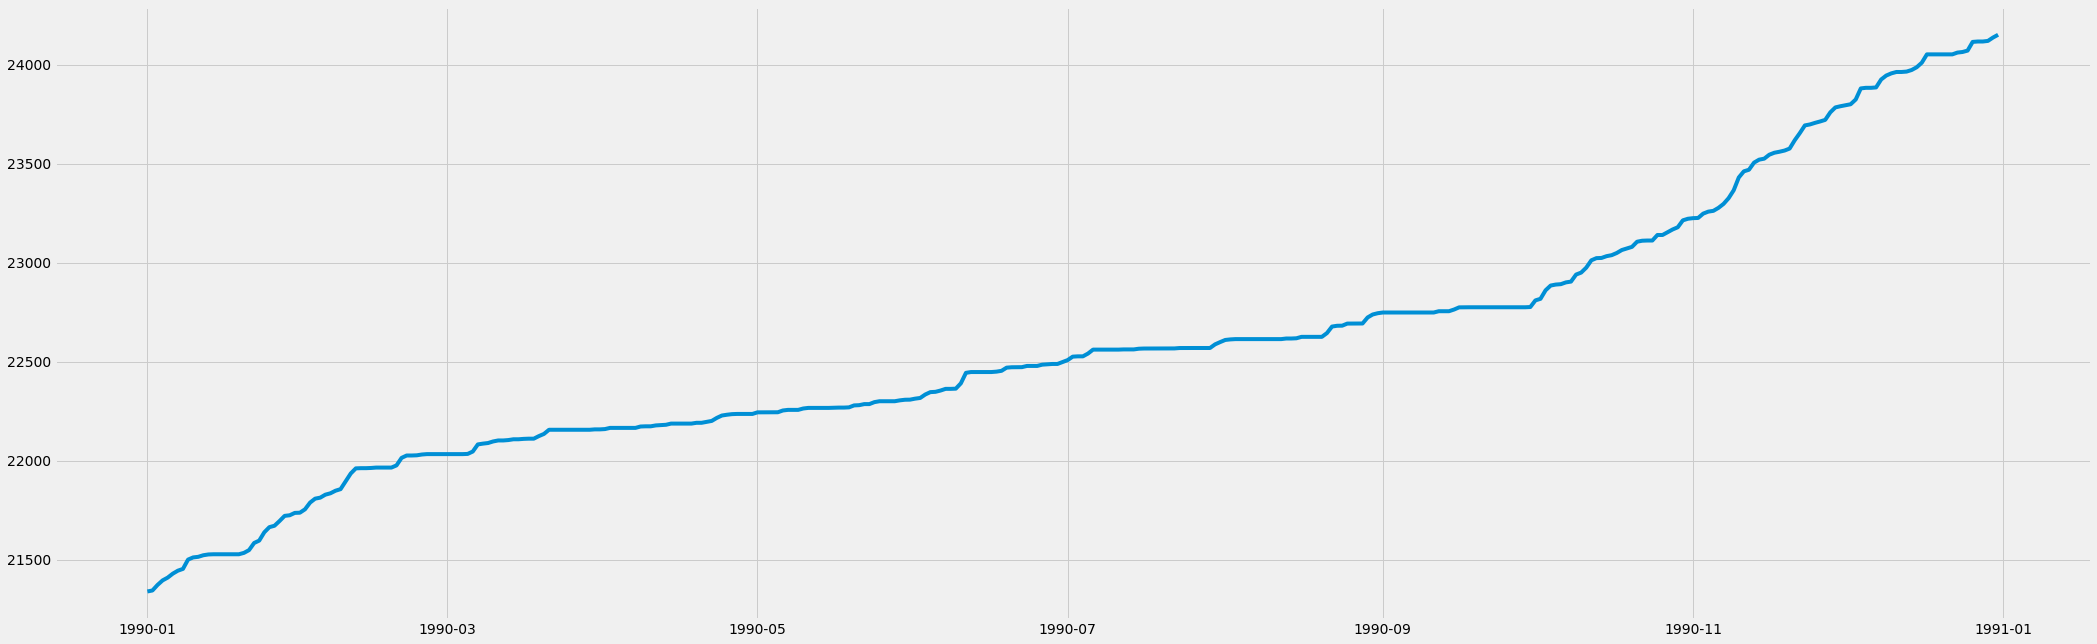

In [141]:
# Expanding window functions
rolling_sum = df['Total_Precip_(mm)'].expanding().sum()

fig, axs = plt.subplots()
fig.set_size_inches(32.5, 10.5)  
sns.lineplot(data = rolling_sum['1990'], ax=axs)

## Trends, seasonality and noise


    - Trend - Consistent upwards or downwards slope of a time series

    - Seasonality - Clear periodic pattern of a time series(like sine funtion)

    - Noise - Outliers or missing values
    
Almost effortless to visulalize the above using StatsModels Seasonal Decompose!

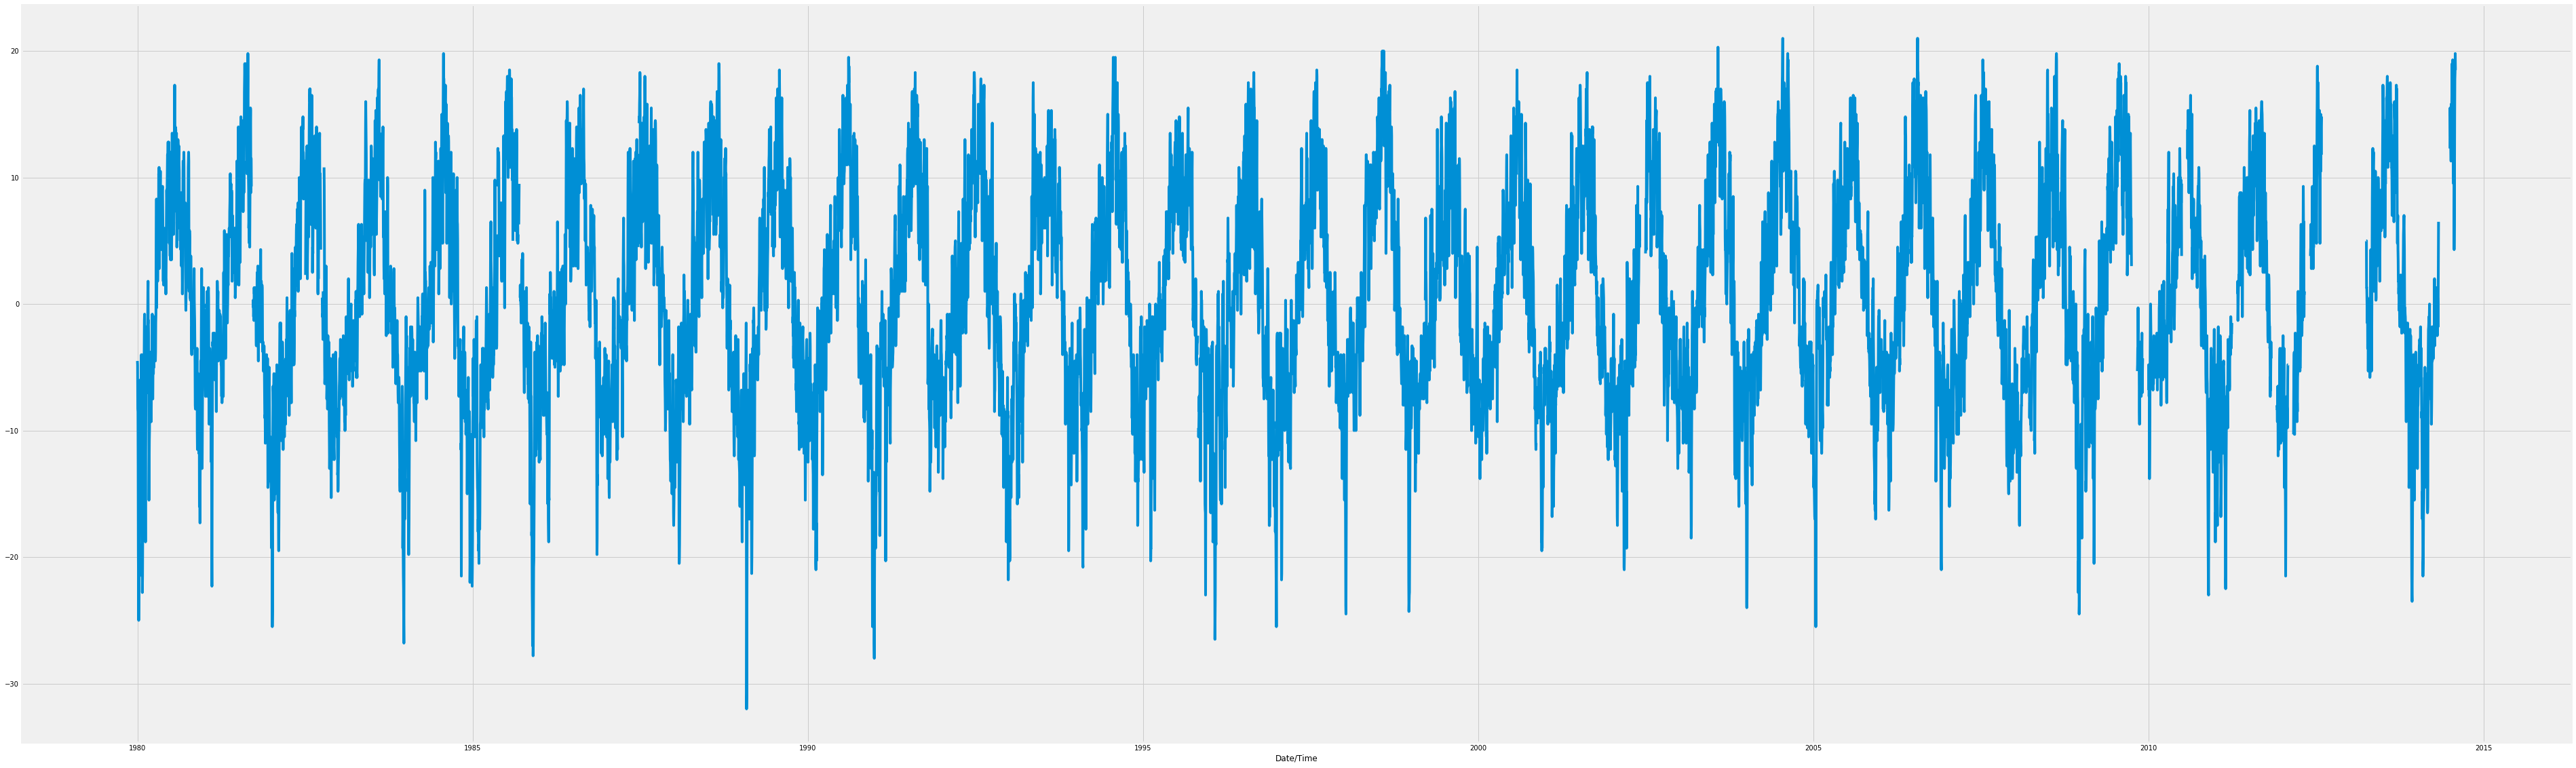

In [156]:

df['Mean_Temp_(°C)'].plot(figsize=(60,20))

In [147]:
df.shape

(14245, 31)

In [154]:
df_dropped = df['Mean_Temp_(°C)'].dropna()

In [196]:
df_dropped = pd.DataFrame(df_dropped)

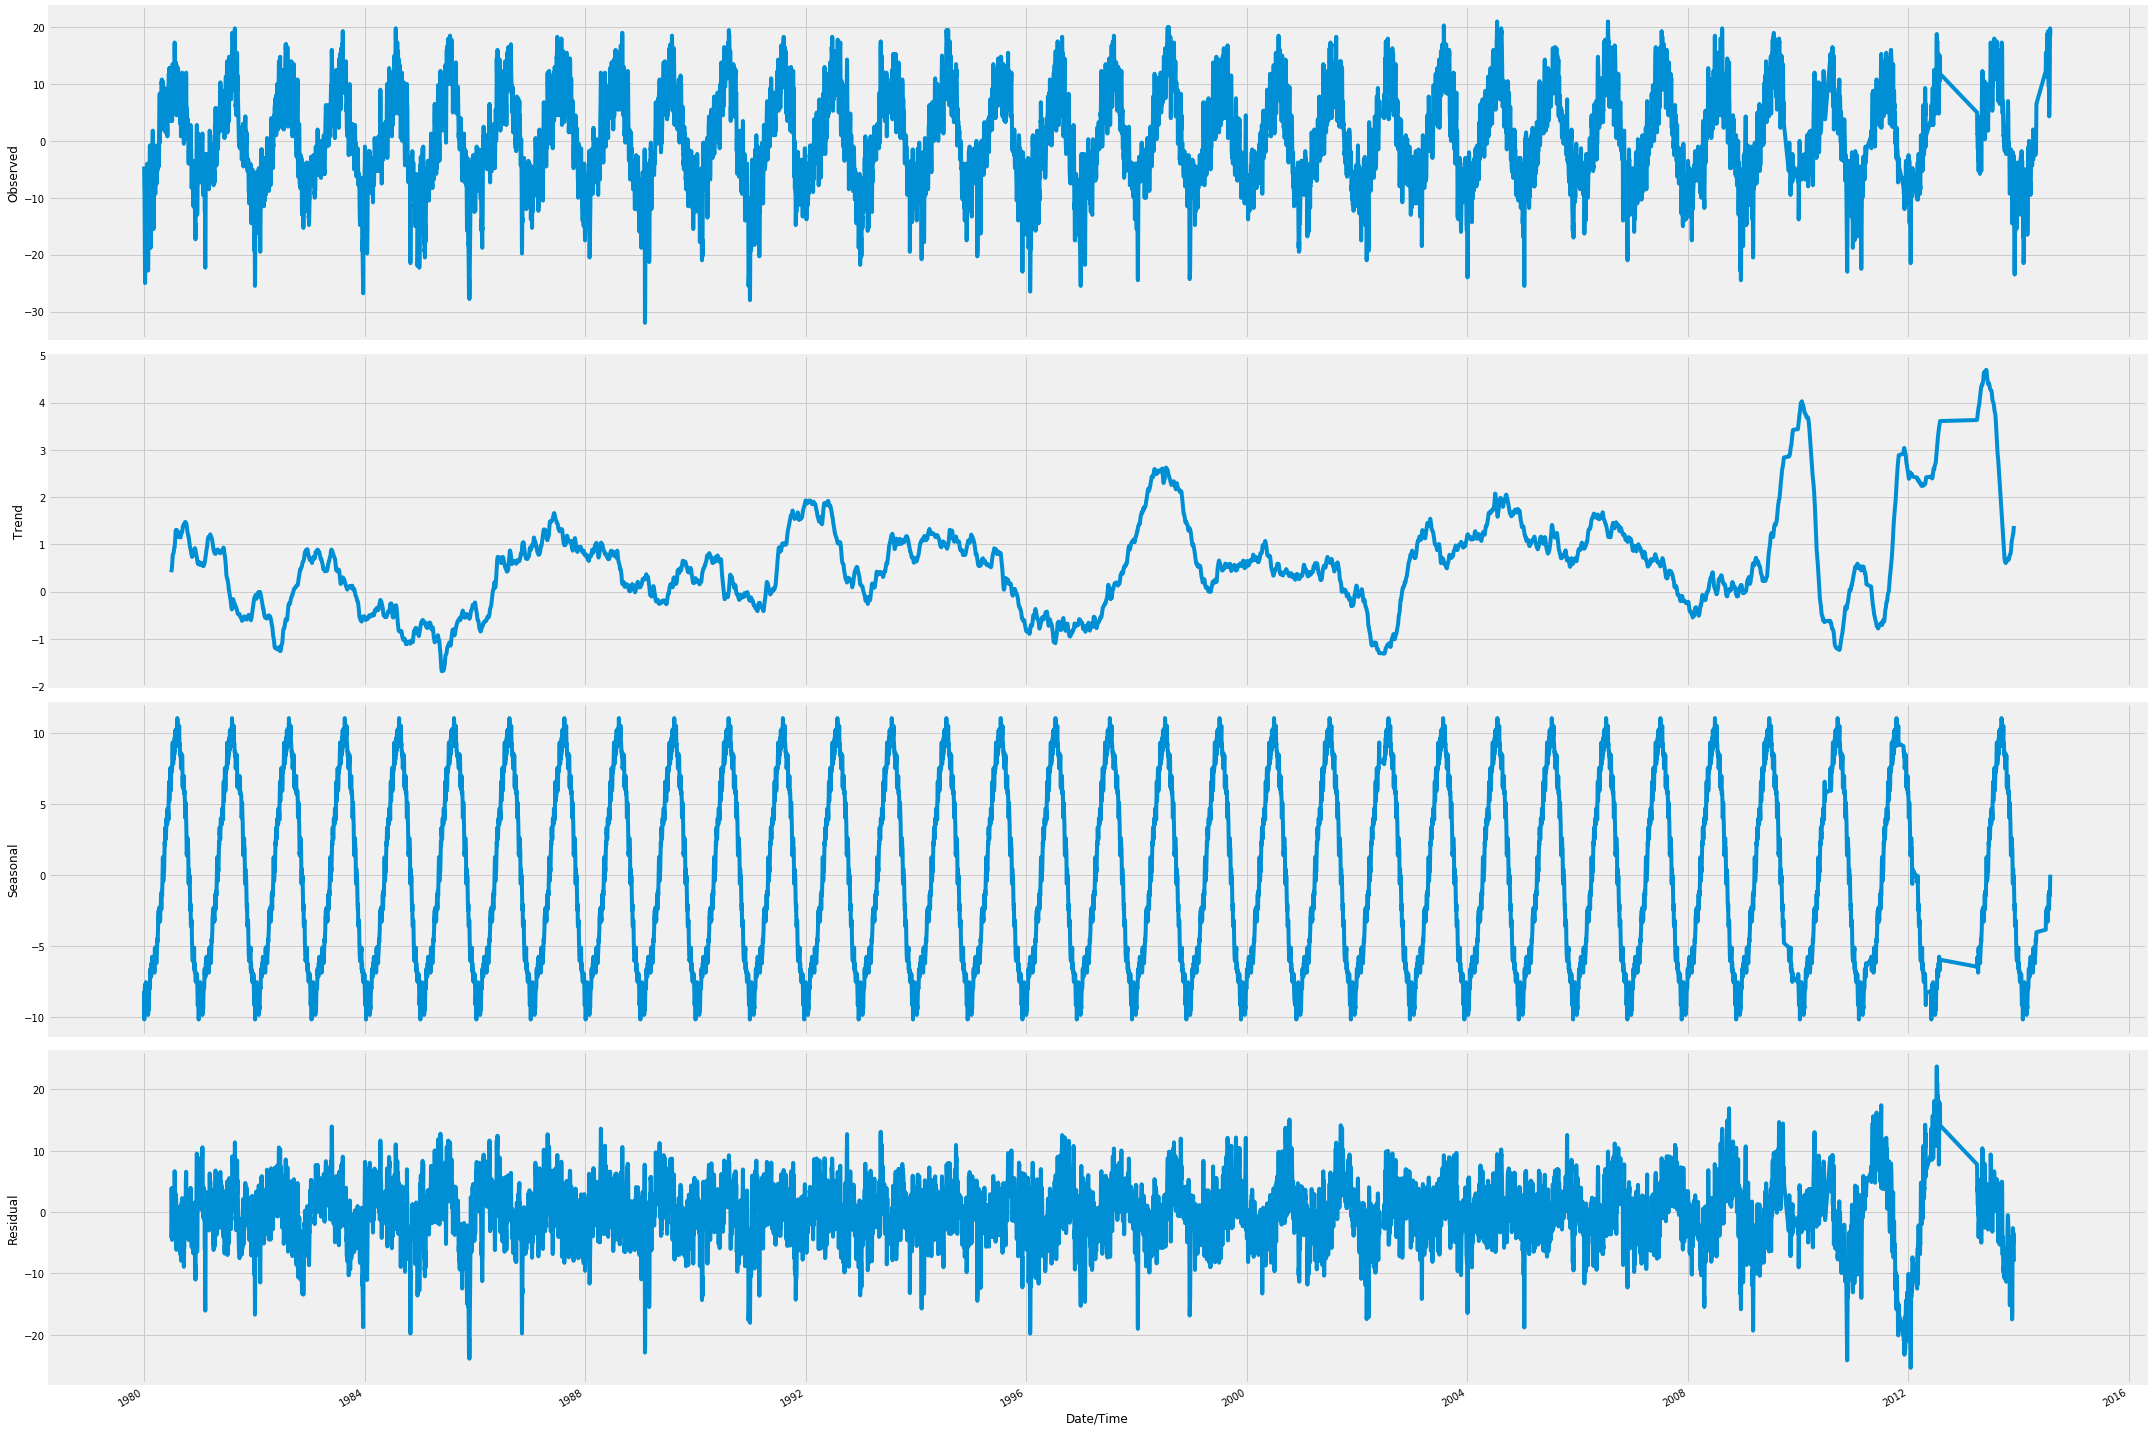

In [201]:
# Now, for decomposition...
rcParams['figure.figsize'] = 30, 20
decomposed_df = sm.tsa.seasonal_decompose(df_dropped, freq=360) # The frequncy is annual
figure = decomposed_df.plot()
plt.show()

### Hopefully this helps clarify what/how/why/when regarding Time Series Analyis.  More to come in future tutorials, such as modeling and predicting!